# Analysis Notebook

In [251]:
import matplotlib
import pandas as pd
import os
import operator

os.chdir("/Users/bencampbell/code_louisville/capstone/louisville-bike-accidents/")

DATAPATH = "data/clean/bike_accidents.csv"
assert os.path.exists(DATAPATH)

DATA = DATA = pd.read_csv(DATAPATH)


In [6]:
# Adding some useful columns and defining some functions for use later in this notebook.

# New Columns
# Boolean value: True -> Casualty (injury or fatality); False -> Noncasualty
DATA['casualty_indicator'] = DATA['fatality_indicator'] | DATA['injury_indicator']
DATA['noncasualty_indicator'] = ~(DATA['fatality_indicator'] | DATA['injury_indicator'])

# Some roadways have a number but no name. Combine these values into a single column. 
# roadway name if any else roadway number. 
DATA['main_roadway'] = DATA['roadway_name'].combine_first(DATA['roadway_number'])
DATA['intersection_roadway'] = DATA['intersection_roadway_name'].combine_first(DATA['intersection_roadway_number'])

# Boolean value: True -> accident occurred in an intersection / between streets
DATA['intersection_indicator'] = DATA['intersection_roadway'].notnull()
DATA['between_street_indicator'] = (
    DATA['between_street_name_1'].notnull() | DATA['between_street_name_2'].notnull() | 
    DATA['between_street_number_1'].notnull() | DATA['between_street_number_2'].notnull())

#DATA.columns

In [7]:
# Useful function definitions / constants
TOTAL_ACCIDENTS = len(DATA) # Total number of accident reports
DANGERMASK = ['fatality_indicator', 'injury_indicator', 'casualty_indicator', 'noncasualty_indicator' ]
# This will get used over and over to analyse relative frequencies of crash outcomes.

def percent_round(x):
    """Create a readable percentage float using round()"""
    return round(x*100, 2)

def percent_format(x):
    """Format a number as a percentage."""
    return format(x, ".2%")


class DangerReport(pd.DataFrame):
    @property
    def totals(df):
        return df['casualties'] + df['noncasualties']
    
    def get_ratio_by_total(df):
        return (df/TOTAL_ACCIDENTS).apply(percent_round)

    def get_ratio_by_value_total(df):
        #totals = df['casualties'] + df['noncasualties']
        return df.apply(lambda x:x/df.totals).apply(percent_round)
    
    def get_danger_ratios(df):
        """total accidents, percent casualty, percent fatality of casualty"""
        out = pd.DataFrame(index=df.index)
        out['total'] = df.totals
        out['percent casualty'] = out.total.combine(df.casualties, lambda T, C:C/T).apply(percent_round)
        out['pct fatality of casualty'] = df.casualties.combine(df.fatalities, lambda C, F:F/C).apply(percent_round)
        out['pct fatality of total'] = df.fatalities.combine(out.total, lambda F, T:F/T).apply(percent_round)
        return out

def get_danger_report(df, label):
    report = df.groupby(label)[DANGERMASK].sum()
    report = report.rename({"injury_indicator":'injuries', 
                          'fatality_indicator':'fatalities',
                          'casualty_indicator':'casualties',
                          'noncasualty_indicator':'noncasualties'}, axis=1)
    return DangerReport(report)

# There's a way to work this into the class definition but I'd rather not struggle with
# __init__ and __new__ definitions right now. 

# lines for testing.
get_danger_report(DATA, 'weather').get_danger_ratios()

,total,percent casualty,pct fatality of casualty,pct fatality of total
weather,,,,
BLOWING SAND/SOIL/DIRT/SNOW,1,100.00,0.00,0.00
CLEAR,1084,71.86,2.82,2.03
CLOUDY,213,72.30,5.19,3.76
FOG WITH RAIN,1,100.00,100.00,100.00
OTHER,2,50.00,0.00,0.00
RAINING,69,76.81,5.66,4.35
SNOWING,4,75.00,0.00,0.00


<Axes: xlabel='hour of day', ylabel='accident count'>

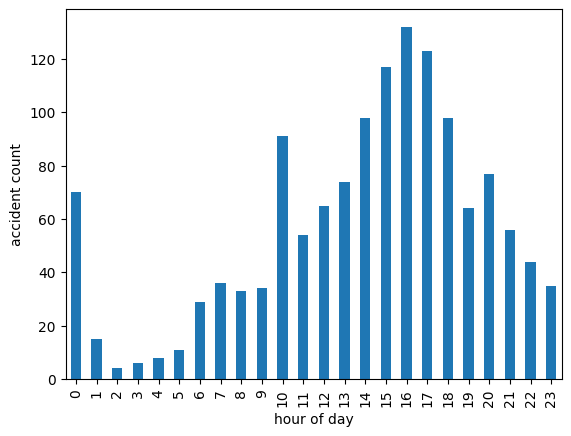

In [8]:
# Time of Day
# show sampling issue with dataset
DATA.groupby('hour').size().plot(kind='bar', xlabel='hour of day', ylabel="accident count")

<Axes: xlabel='hour of day', ylabel='count of light_condition == DAYLIGHT'>

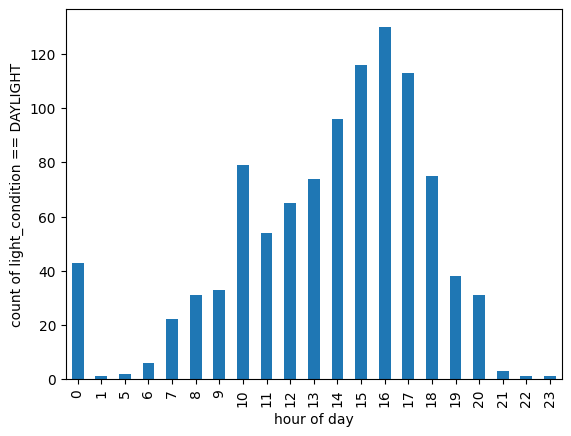

In [9]:
hour_light = DATA[['hour', 'light_condition']]
hour_light[hour_light['light_condition'] == "DAYLIGHT"].groupby('hour').size().plot(
    kind='bar', xlabel='hour of day', ylabel='count of light_condition == DAYLIGHT')

<Axes: xlabel='hour of day', ylabel='DAYLIGHT'>

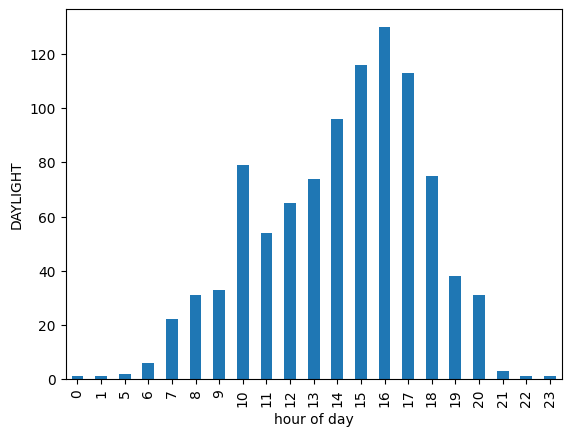

In [10]:
zeros = DATA[(DATA.hour==0) & (DATA.minute==0)]
# Get all rows that have 00:00 time value


#zeros[zeros['date'].apply(lambda x:x.second==0)]
# Check that the seconds are zero too.

zeros_index = zeros[zeros['light_condition'] == "DAYLIGHT"].index
# For recrods that have 00:00 time, find the ones that have light_condition == DAYLIGHT, 
# then filter these records out of my data:

filtered_light = DATA[~DATA.index.isin(zeros_index)]
# Now let's see what the time distribution for DAYLIGHT condition looks like:
filtered_light[filtered_light['light_condition'] == "DAYLIGHT"].groupby('hour').size().plot(
    kind='bar', ylabel='DAYLIGHT', xlabel='hour of day')

In [11]:
filtered_light[filtered_light.light_condition == 'OTHER']['date'] # 10:20PM It's dark.
filtered_light.light_condition.replace(to_replace="OTHER", value='DARK')

0        DARK-HWY LIGHTED/ON
1                   DAYLIGHT
2                   DAYLIGHT
3                   DAYLIGHT
4                   DAYLIGHT
                ...         
1369                DAYLIGHT
1370                DAYLIGHT
1371                DAYLIGHT
1372                DAYLIGHT
1373    DARK-HWY NOT LIGHTED
Name: light_condition, Length: 1332, dtype: object

In [12]:
#r = DangerReport(filtered_light.groupby('light_condition')[DANGERMASK].sum())
LC = get_danger_report(filtered_light, 'light_condition')
LC = LC.drop('OTHER', axis=0) 
# Only one record with value == OTHER. Dropping it since it's probably not significant.
LC.get_ratio_by_value_total().sort_values(by='casualties', ascending=False)

,fatalities,injuries,casualties,noncasualties
light_condition,,,,
DARK-HWY NOT LIGHTED,25.81,67.74,93.55,6.45
DARK-HWY LIGHTED/OFF,7.69,80.77,88.46,11.54
DARK (UNKNOWN ROADWAY LIGHTING),0.00,85.71,85.71,14.29
DAWN,0.00,74.19,74.19,25.81
DARK-HWY LIGHTED/ON,0.57,72.00,72.57,27.43
DAYLIGHT,1.34,69.14,70.37,29.63
DUSK,1.72,67.24,68.97,31.03


<Axes: xlabel='None,light_condition'>

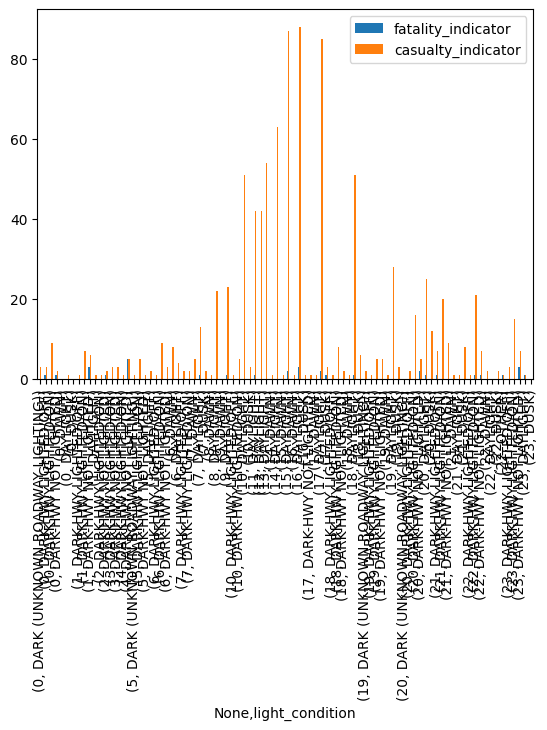

In [13]:
def hour_grouper(location):
    hour = filtered_light.loc[location].hour
    return hour


filtered_light.groupby([hour_grouper, 'light_condition'])[DANGERMASK].sum()[['fatality_indicator', 'casualty_indicator']].plot.bar()

In [14]:
filtered_light.groupby(['light_condition'])['hour'].unique()

light_condition
DARK (UNKNOWN ROADWAY LIGHTING)                                       [0, 20, 19, 5]
DARK-HWY LIGHTED/OFF                        [21, 20, 23, 6, 0, 18, 22, 19, 7, 10, 1]
DARK-HWY LIGHTED/ON                [10, 21, 22, 3, 1, 23, 20, 6, 0, 5, 19, 18, 7,...
DARK-HWY NOT LIGHTED               [19, 4, 21, 22, 23, 6, 3, 5, 0, 20, 1, 17, 18, 2]
DAWN                                 [22, 7, 6, 9, 15, 8, 18, 16, 17, 0, 14, 21, 19]
DAYLIGHT                           [13, 15, 6, 18, 17, 16, 9, 12, 14, 10, 8, 19, ...
DUSK                                      [20, 10, 17, 21, 19, 23, 18, 22, 16, 7, 0]
OTHER                                                                           [22]
Name: hour, dtype: object

In [15]:
RC = get_danger_report(DATA, 'roadway_condition')
RC.get_danger_ratios()

,total,percent casualty,pct fatality of casualty,pct fatality of total
roadway_condition,,,,
DRY,1261,71.69,3.21,2.30
ICE,1,100.00,0.00,0.00
SNOW/SLUSH,4,75.00,0.00,0.00
WATER (STANDING OR MOVING),2,0.00,NaN,0.00
WET,106,79.25,5.95,4.72


In [16]:

RC_copy = RC.copy()
RC_copy.loc['WET'] = RC.iloc[1:].sum()
RC_copy = RC_copy.loc[['DRY', 'WET']]
RC_copy

,fatalities,injuries,casualties,noncasualties
roadway_condition,,,,
DRY,29,876,904,357
WET,5,83,88,25


In [17]:
RC_copy.get_ratio_by_value_total()
RC_copy.get_danger_ratios()[['percent casualty', 'pct fatality of casualty']]#.plot.pie(subplots=True)

,percent casualty,pct fatality of casualty
roadway_condition,,
DRY,71.69,3.21
WET,77.88,5.68


In [18]:
DATA.roadway_condition.unique()


array(['DRY', 'WET', 'SNOW/SLUSH', 'WATER (STANDING OR MOVING)', 'ICE'],
      dtype=object)

In [19]:
def RC_grouper(loc):
    if DATA.loc[loc].roadway_condition != 'DRY':
        return 'WET'
    else:
        return 'DRY'
    
DATA.groupby(by=[RC_grouper])[DANGERMASK].sum()

,fatality_indicator,injury_indicator,casualty_indicator,noncasualty_indicator
DRY,29,876,904,357
WET,5,83,88,25


In [20]:
weather_report = get_danger_report(DATA, 'weather')
weather_report#.get_ratio_by_value_total()


,fatalities,injuries,casualties,noncasualties
weather,,,,
BLOWING SAND/SOIL/DIRT/SNOW,0,1,1,0
CLEAR,22,758,779,305
CLOUDY,8,146,154,59
FOG WITH RAIN,1,0,1,0
OTHER,0,1,1,1
RAINING,3,50,53,16
SNOWING,0,3,3,1


In [21]:
DangerReport(weather_report[weather_report.casualties >3]).get_ratio_by_value_total()

,fatalities,injuries,casualties,noncasualties
weather,,,,
CLEAR,2.03,69.93,71.86,28.14
CLOUDY,3.76,68.54,72.30,27.70
RAINING,4.35,72.46,76.81,23.19


In [22]:
DATA.groupby(['weather', 'light_condition'])[DANGERMASK].sum().sort_values(by='casualty_indicator', ascending=False)

fatality_indicator  \
weather                     light_condition                                       
CLEAR                       DAYLIGHT                                         12   
CLOUDY                      DAYLIGHT                                          0   
CLEAR                       DARK-HWY LIGHTED/ON                               1   
                            DARK-HWY NOT LIGHTED                              6   
                            DUSK                                              1   
RAINING                     DAYLIGHT                                          1   
CLEAR                       DAWN                                              0   
CLOUDY                      DARK-HWY LIGHTED/ON                               0   
CLEAR                       DARK-HWY LIGHTED/OFF                              1   
CLOUDY                      DARK-HWY NOT LIGHTED                              8   
RAINING                     DARK-HWY LIGHTED/ON                               0   
CLOUDY                      DUSK                                              0   
RAINING                     DARK-HWY NOT LIGHTED                              1   
                            DARK-HWY LIGHTED/OFF                              1   
CLEAR                       DARK (UNKNOWN ROADWAY LIGHTING)                   0   
CLOUDY                      DAWN                                              0   
RAINING                     DUSK                                              0   
                            DAWN                                              0   
SNOWING                     DARK-HWY LIGHTED/ON                               0   
BLOWING SAND/SOIL/DIRT/SNOW DARK-HWY LIGHTED/ON                               0   
OTHER                       DARK (UNKNOWN ROADWAY LIGHTING)                   0   
FOG WITH RAIN               DARK-HWY NOT LIGHTED                              1   
CLOUDY                      DARK-HWY LIGHTED/OFF                              0   
CLEAR                       OTHER                                             1   
SNOWING                     DUSK                                              0   
OTHER                       DARK-HWY LIGHTED/ON                               0   
SNOWING                     DAYLIGHT                                          0   

                                                             injury_indicator  \
weather                     light_condition                                     
CLEAR                       DAYLIGHT                                      573   
CLOUDY                      DAYLIGHT                                      108   
CLEAR                       DARK-HWY LIGHTED/ON                            91   
                            DARK-HWY NOT LIGHTED                           27   
                            DUSK                                           28   
RAINING                     DAYLIGHT                                       21   
CLEAR                       DAWN                                           18   
CLOUDY                      DARK-HWY LIGHTED/ON                            18   
CLEAR                       DARK-HWY LIGHTED/OFF                           16   
CLOUDY                      DARK-HWY NOT LIGHTED                            9   
RAINING                     DARK-HWY LIGHTED/ON                            14   
CLOUDY                      DUSK                                            7   
RAINING                     DARK-HWY NOT LIGHTED                            6   
                            DARK-HWY LIGHTED/OFF                            4   
CLEAR                       DARK (UNKNOWN ROADWAY LIGHTING)                 5   
CLOUDY                      DAWN                                            3   
RAINING                     DUSK                                            3   
                            DAWN                                            2   
SNOWING                     DARK-

In [23]:
# Most dangerous roads?

#top_most_dangerous_roads = 
# Group by road type?
# Find percents by this: what percent of accidents occur in these most dangerous roads.
#top_most_dangerous_roads.plot(kind='bar', ylabel='value count')



<Axes: xlabel='main_roadway'>

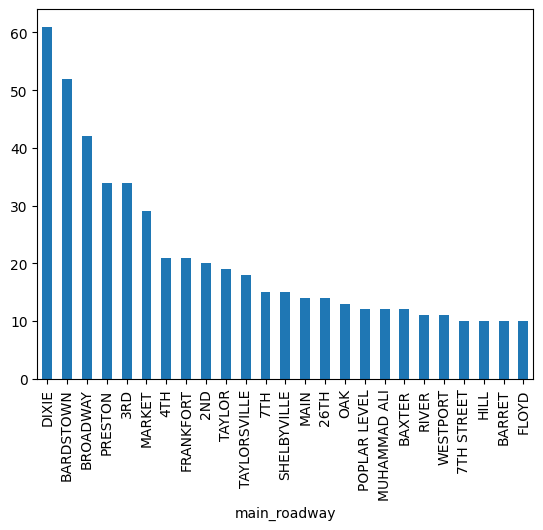

In [24]:
roadwaygroup = DATA.groupby(['main_roadway'])

roadwaygroup.size().sort_values(ascending=False).head(25).plot.bar()

In [25]:
roadwaygroup[DANGERMASK].sum().sort_values(by=['casualty_indicator'], ascending=False).head(25)

,fatality_indicator,injury_indicator,casualty_indicator,noncasualty_indicator
main_roadway,,,,
DIXIE,2,51,53,8
BROADWAY,0,30,30,12
BARDSTOWN,2,26,28,24
PRESTON,3,24,27,7
MARKET,0,19,19,10
TAYLORSVILLE,0,18,18,0
3RD,0,18,18,16
4TH,0,17,17,4
2ND,0,14,14,6


<Axes: >

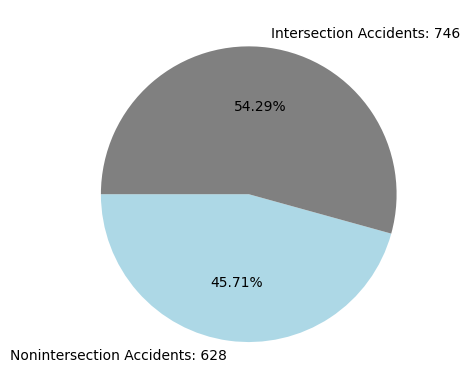

In [239]:
# Intersections vs non intersections and lighted intersections

report = get_danger_report(DATA, 'intersection_indicator')
totals = report.casualties + report.noncasualties
report['total'] = totals
labels = [f"Nonintersection Accidents: {totals[False]}", f"Intersection Accidents: {totals[True]}"]
totals.plot.pie(labels=labels, autopct='%.2f%%', startangle=180, colors = ['lightblue', 'grey'])



<Axes: >

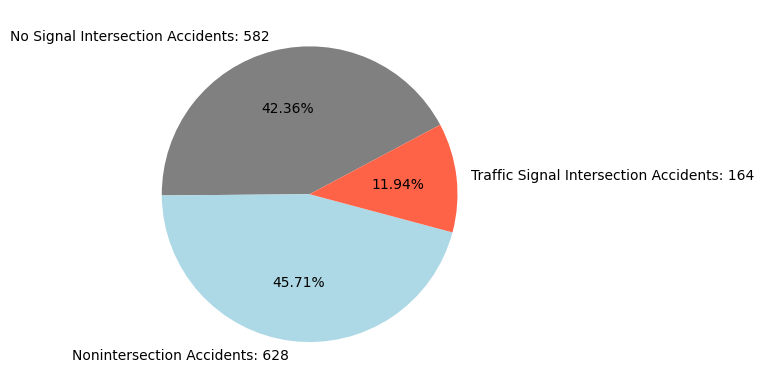

In [217]:

def crash_site_grouper(df, location):
    row = df.loc[location]
    if row.intersection_indicator == True:
        if row.lighted_signal_indicator == True:
            return 'Traffic Light'
        else:
            return 'Intersection'
    else:
        return 'Nonintersection'
    

site_report = pd.DataFrame(DATA.groupby(by=lambda x:crash_site_grouper(DATA, x))[DANGERMASK].sum())
totals = site_report.casualty_indicator + site_report.noncasualty_indicator
totals = totals.rename({"Traffic Light":"Traffic Signal Intersection Accidents",
               "Intersection": "No Signal Intersection Accidents",
               "Nonintersection":"Nonintersection Accidents"})
totals.plot.pie(autopct="%.2f%%", ylabel='', startangle=28, 
                colors=['grey', 'lightblue', 'tomato'], 
                #hatch=['', '', 'ooo'],
        labels=["{key}: {value}".format(key=key, value=value) for key, value in totals.to_dict().items()])

,% casualty,% fatality,% all accidents
intersection_indicator,,,
False,70.86,4.30,45.71
True,73.32,0.94,54.29


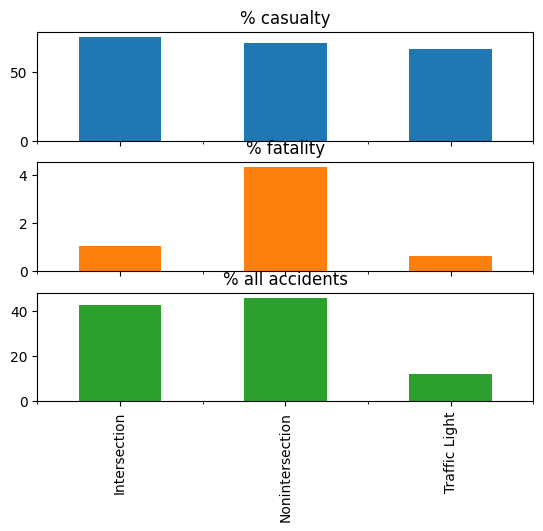

In [249]:
site_report['total'] = site_report.casualty_indicator + site_report.noncasualty_indicator
site_report['% casualty'] = (site_report.casualty_indicator / site_report.total).apply(percent_round)
site_report['% fatality'] = (site_report.fatality_indicator/ site_report.total).apply(percent_round)
site_report['% all accidents'] = (site_report.total / TOTAL_ACCIDENTS).apply(percent_round)
site_report.iloc[:,-3:].plot.bar(subplots=True, legend=False)
report['% casualty'] = (report.casualties/ report.total).apply(percent_round)
report['% fatality'] = (report.fatalities/ report.total).apply(percent_round)
report['% all accidents'] = (report.total / TOTAL_ACCIDENTS).apply(percent_round)
report.iloc[:,-3:]

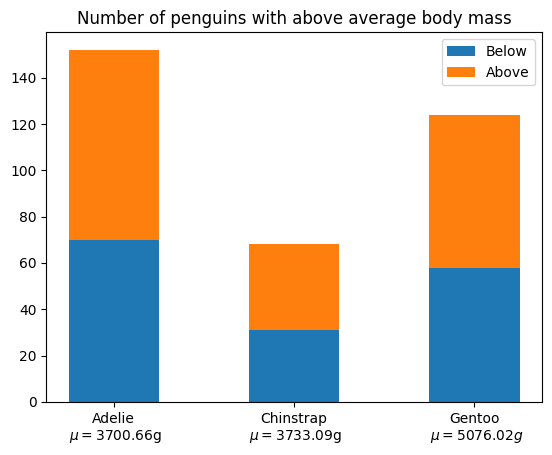

In [253]:
import matplotlib.pyplot as plt
import numpy as np

species = (
    "Adelie\n $\\mu=$3700.66g",
    "Chinstrap\n $\\mu=$3733.09g",
    "Gentoo\n $\\mu=5076.02g$",
)
weight_counts = {
    "Below": np.array([70, 31, 58]),
    "Above": np.array([82, 37, 66]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper right")

plt.show()